# Task 1: Acquire the data


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
import copy
import pandas as pd
import seaborn as sns

drive.mount('/content/drive')

# dataset_path = "/content/drive/My Drive/COMP 551 - A3 - Shared/kmnist/"

dataset_path = "/content/Shared with me/COMP 551 - A3 - Shared/kmnist/"

Mounted at /content/drive


Training data shape: (60000, 784), Training labels shape: (60000,)
Test data shape: (10000, 784), Test labels shape: (10000,)


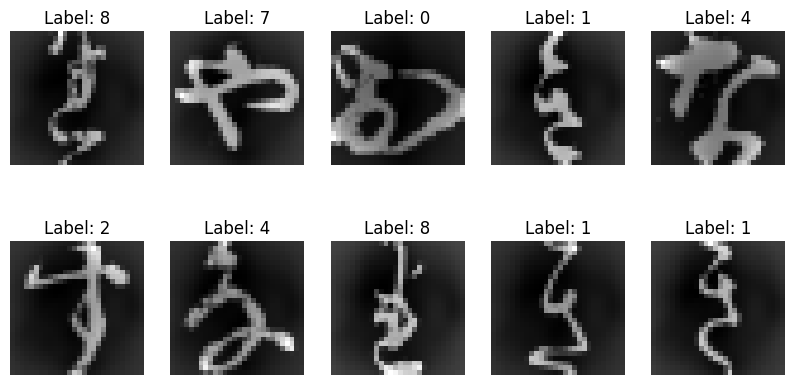

In [ ]:
train_imgs_path = "/content/drive/My Drive/kmnist/kmnist-train-imgs.npz"
train_labels_path = "/content/drive/My Drive/kmnist/kmnist-train-labels.npz"
test_imgs_path = "/content/drive/My Drive/kmnist/kmnist-test-imgs.npz"
test_labels_path = "/content/drive/My Drive/kmnist/kmnist-test-labels.npz"

# Load training set (60K images)
X_train = np.load(train_imgs_path)["arr_0"]
y_train = np.load(train_labels_path)["arr_0"]

# Load test set (10K images)
X_test = np.load(test_imgs_path)["arr_0"]
y_test = np.load(test_labels_path)["arr_0"]

#flatten images to 1 × 784 vectors
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

#standardization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

#verify dataset shape
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

#visualize some samples
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()

X_train, y_train, X_val, y_val = X_train[:50000], y_train[:50000], X_train[50000:], y_train[50000:]

# Task 2: MLP implementation

## Activation functions

In [44]:
class Cross_Entropy:
    def __init__(self, activation_fn):
        self.activation_fn = activation_fn

    def activation(self, z):
        return self.activation_fn.activation(z)

    def loss_computation(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        return -np.sum(y_true * np.log(y_pred)) / N

    @staticmethod
    def prime(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return y_pred - y_true


class Relu:
    @staticmethod
    def activation(z):
        return np.maximum(0, z)

    @staticmethod
    def prime(z):
        return (z > 0).astype(float)


class LeakyRelu:
    @staticmethod
    def activation(z):
        return np.where(z > 0, z, 0.01 * z)

    @staticmethod
    def prime(z):
        return np.where(z > 0, 1, 0.01)


class Softmax:
    @staticmethod
    def activation(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    @staticmethod
    def prime(x):
        s = Softmax.activation(x)
        return s * (1 - s)


class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def prime(z):
        s = Sigmoid.activation(z)
        return s * (1 - s)



## MLP

In [ ]:
class MLP:
    def __init__(self, activation_funcs, input_size=784, hidden_layers=[128, 64], output_size=10):
        """
        activation_funcs: list of activation function classes (e.g., [Relu, Relu, Softmax])
        input_size: number of input features (default = 784 for MNIST)
        hidden_layers: list with sizes of each hidden layer
        output_size: number of output classes (e.g., 10 for classification)
        """
        self.learning_rate = None
        self.lambd = None
        self.loss_fn = None
        self.best_iteration = 0

        # Build layer sizes: input + hidden + output
        layer_dims = [input_size] + hidden_layers + [output_size]
        self.n_layers = len(layer_dims)

        self.W = {}
        self.bias = {}
        self.activations = {}

        for i in range(1, self.n_layers):
            self.W[i] = np.random.randn(layer_dims[i - 1], layer_dims[i]) / np.sqrt(layer_dims[i - 1])
            self.bias[i] = np.zeros((1, layer_dims[i]))
            self.activations[i + 1] = activation_funcs[i - 1]  # Activation for layer i comes after layer i-1 → index offset

        # Save best weights/biases
        self.best_W = {k: np.copy(v) for k, v in self.W.items()}
        self.best_bias = {k: np.copy(v) for k, v in self.bias.items()}
        self.best_acc = 0


    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size, loss_fn, lambd, learning_rate=1e-3):
        """
          - X_train, y_train: Training data and labels.
          - X_test, y_test: Test data and labels.
          - epochs: Number of training epochs.
          - batch_size: Size of mini-batches for SGD.
          - loss_fn: Loss function class (Cross_Entropy).
          - lambd: Regularization strength. (L2 regularization)
          - learning_rate: Learning rate for gradient descent.
        """

        # One hot encoding
        if y_train.ndim == 1:
            y_train = np.eye(10)[y_train]  # creates a 10x10 identity matrix because we have 10 digits in the dataset 0-9
        if y_test.ndim == 1:
            y_test = np.eye(10)[y_test]

        if not X_train.shape[0] == y_train.shape[0]:
            raise ValueError("Mismatch: X_train and y_train must have the same number of samples.")

        self.loss_fn = loss_fn(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        self.lambd = lambd
        train_accuracies = []
        val_accuracies = []
        los = []

        for i in range(epochs):
            indices = np.random.permutation(X_train.shape[0])
            x_ = X_train[indices]
            y_ = y_train[indices]

            for j in range(X_train.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_prop(z, a, y_[k:l])

            if (i + 1) % 10 == 0:
                _, a = self.feed_forward(X_train, test_prediction=False)  # We are not doing predictions on the test set so False
                y_pred = a[self.n_layers]
                los.append(self.loss_fn.loss_computation(y_train, y_pred))

            # Track accuracy
            train_acc = np.mean(self.predict(X_train, in_function=True) == np.argmax(y_train, axis=1))
            val_acc = np.mean(self.predict(X_test, in_function=True) == np.argmax(y_test, axis=1))
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            # Keep best weights based on the highest test accuracy
            if  val_acc > self.best_acc:
                self.best_iteration = i
                self.best_acc = val_acc
                self.best_W = {key: np.copy(val) for key, val in self.W.items()}
                self.best_bias = {key: np.copy(val) for key, val in self.bias.items()}


        return train_accuracies, val_accuracies


    def feed_forward(self, x, test_prediction=False, custom_weights=None):
      z = {}
      a = {1: x}
      W = self.best_W if test_prediction else (custom_weights if custom_weights is not None else self.W)


      for i in range(1, self.n_layers):
          z[i + 1] = np.dot(a[i], W[i]) + self.bias[i]
          a[i + 1] = self.activations[i + 1].activation(z[i + 1])
      return z, a


    def back_prop(self, z, a, y_true):
        """
        Implements Backpropagation.
        """
        delta = self.loss_fn.delta(y_true, a[self.n_layers])
        dw = np.dot(a[self.n_layers - 1].T, delta) / y_true.shape[0]
        update_params = {self.n_layers - 1: (dw, delta)}
        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.W[i].T) * self.activations[i].prime(z[i])
            dw = np.dot(a[i - 1].T, delta)/ y_true.shape[0]
            update_params[i - 1] = (dw, delta)

        for k, v in update_params.items():
            self.update_w_b(k, v[0], v[1])



    def update_w_b(self, index, dw, delta):
        """
        Updates weights and biases using gradient descent.
        """
        dw += (self.lambd) * self.W[index]
        self.W[index] -= self.learning_rate * dw
        self.bias[index] -= self.learning_rate * np.mean(delta, axis=0)



    def predict(self, x, in_function=False):
        """
        Makes predictions using the trained model.
        - x: Input data.
        - in_function: Indicates whether we are doing predictions inside the fit function or not (on the test set).
        """
        if in_function:
          _, a = self.feed_forward(x, test_prediction=False)
        else:
          _, a = self.feed_forward(x, test_prediction=True)
        return np.argmax(a[self.n_layers],axis=1)


def evaluate_acc (true_label, prediction):
    return np.sum(true_label == prediction)/prediction.shape[0]

## Training and testing example

Test Accuracy: 0.8338


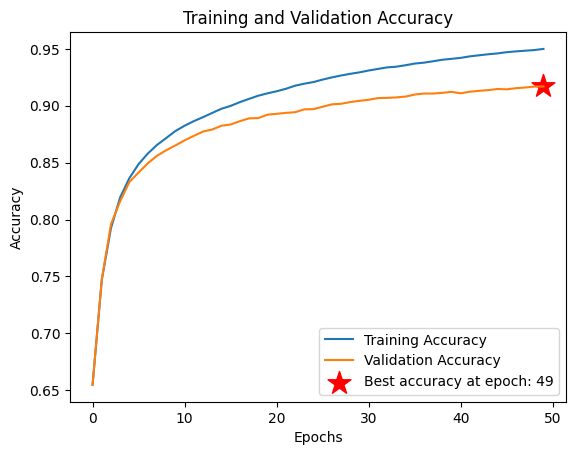

In [ ]:
# MLP model
mlp = MLP(input_size=784, hidden_layers=[64, 64], output_size=10, activation_funcs=(Relu, Relu, Softmax))

train_acc, val_acc = mlp.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd=0)

y_pred_test = mlp.predict(X_test)
test_acc = evaluate_acc(y_test, y_pred_test)
print(f"Test Accuracy: {test_acc:.4f}")

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.scatter(mlp.best_iteration, mlp.best_acc, color='red', marker='*', s=300, label=f"Best accuracy at epoch: {mlp.best_iteration}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Gradient checking

In [ ]:
def numerical_gradient_dict(f, params, epsilon=1e-5):
    numerical_grads = {}
    for key in params:
        grad = np.zeros_like(params[key])
        for i in range(params[key].shape[0]):
            for j in range(params[key].shape[1]):
                theta_plus = copy.deepcopy(params)
                theta_minus = copy.deepcopy(params)

                theta_plus[key][i, j] += epsilon
                theta_minus[key][i, j] -= epsilon

                J_plus = f(theta_plus)
                J_minus = f(theta_minus)

                grad[i, j] = (J_plus - J_minus) / (2 * epsilon)

        numerical_grads[key] = grad
    return numerical_grads

def gradient_checking(model, X_sample, y_sample):
    """
    Verifies the gradients of the MLP using numerical approximation.
    Assumes y_sample is one-hot encoded.
    """
    z, a = model.feed_forward(X_sample)


    delta = model.loss_fn.delta(y_sample, a[model.n_layers])
    analytical_grads = {}
    analytical_grads[model.n_layers - 1] = np.dot(a[model.n_layers - 1].T, delta) / y_sample.shape[0]

    for i in reversed(range(2, model.n_layers)):
        delta = np.dot(delta, model.W[i].T) * model.activations[i].prime(z[i])
        analytical_grads[i - 1] = np.dot(a[i - 1].T, delta) / y_sample.shape[0]



    def loss_func(custom_W):
      z, a = model.feed_forward(X_sample, custom_weights=custom_W)
      y_pred = a[model.n_layers]
      loss = -np.sum(y_sample * np.log(y_pred + 1e-8)) / y_sample.shape[0]

      return loss


    numerical_grads = numerical_gradient_dict(loss_func, model.W)

    for key in analytical_grads:
        num_grad = numerical_grads[key]
        anal_grad = analytical_grads[key]
        diff = np.linalg.norm(anal_grad - num_grad) / (np.linalg.norm(anal_grad) + np.linalg.norm(num_grad) + 1e-8)
        print(f"Gradient difference for layer {key}: {diff:.8f}")
        if diff > 1e-4:
            print("Possible gradient error in layer", key)


X_sample = X_train[:50]
y_sample = y_train[:50]
y_sample = np.eye(10)[y_sample]

mlp = MLP(input_size=784, hidden_layers=[64, 64], output_size=10, activation_funcs=(Relu, Relu, Softmax))
train_acc, val_acc = mlp.fit(X_train, y_train, X_val, y_val, epochs=20, batch_size=32, loss_fn=Cross_Entropy, lambd=0)
gradient_checking(mlp, X_sample, y_sample)


Gradient difference for layer 3: 0.00000003
Gradient difference for layer 2: 0.00000004
Gradient difference for layer 1: 0.00000004


## Hyperparameter tuning

### Tuning for 2 layers MLP

In [ ]:
class MLPClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layers=(128, 64), learning_rate=0.01, batch_size=64):
        self.hidden_layers = tuple(hidden_layers)  #store as tuple to avoid cloning issues
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = None


    def fit(self, X, y):
      activation_funcs = [Relu] * (len(self.hidden_layers)) + [Softmax]

      self.model = MLP(
          activation_funcs=activation_funcs,
          input_size=784,
          hidden_layers=list(self.hidden_layers),
          output_size=10
      )

      from sklearn.model_selection import train_test_split
      X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

      self.train_acc, self.val_acc = self.model.fit(
          X_train, y_train,
          X_val, y_val,
          epochs=20,
          batch_size=self.batch_size,
          learning_rate=self.learning_rate,
          loss_fn=Cross_Entropy,
          lambd=0
      )
      return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return evaluate_acc(y, y_pred)

In [ ]:
#this takes a long time to run!! took me ~50mins
param_grid = {
     'hidden_layers': [(64, 64), (128, 128), (128, 64), (256, 128)],
     'learning_rate': [0.001, 0.01, 0.05],
     'batch_size': [32, 64, 128]
}

grid_search = GridSearchCV(MLPClassifierWrapper(), param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

#best hyperparameters
print("Best Parameters:", grid_search.best_params_)

#testign best model
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = evaluate_acc(y_test, y_test_pred)

print(f"Best Test Accuracy: {test_accuracy:.4f}")

# # output:
# # Fitting 3 folds for each of 27 candidates, totalling 81 fits
# # Epoch 1/10, Accuracy: 0.9526
# # Epoch 2/10, Accuracy: 0.9701
# # Epoch 3/10, Accuracy: 0.9819
# # Epoch 4/10, Accuracy: 0.9922
# # Epoch 5/10, Accuracy: 0.9928
# # Epoch 6/10, Accuracy: 0.9959
# # Epoch 7/10, Accuracy: 0.9958
# # Epoch 8/10, Accuracy: 0.9992
# # Epoch 9/10, Accuracy: 0.9997
# # Epoch 10/10, Accuracy: 0.9997
# # Best Parameters: {'batch_size': 32, 'hidden_layers': (256, 128, 64), 'learning_rate': 0.05}
# # Best Test Accuracy: 0.9023

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'batch_size': 32, 'hidden_layers': (256, 128), 'learning_rate': 0.05}
Best Test Accuracy: 0.8907


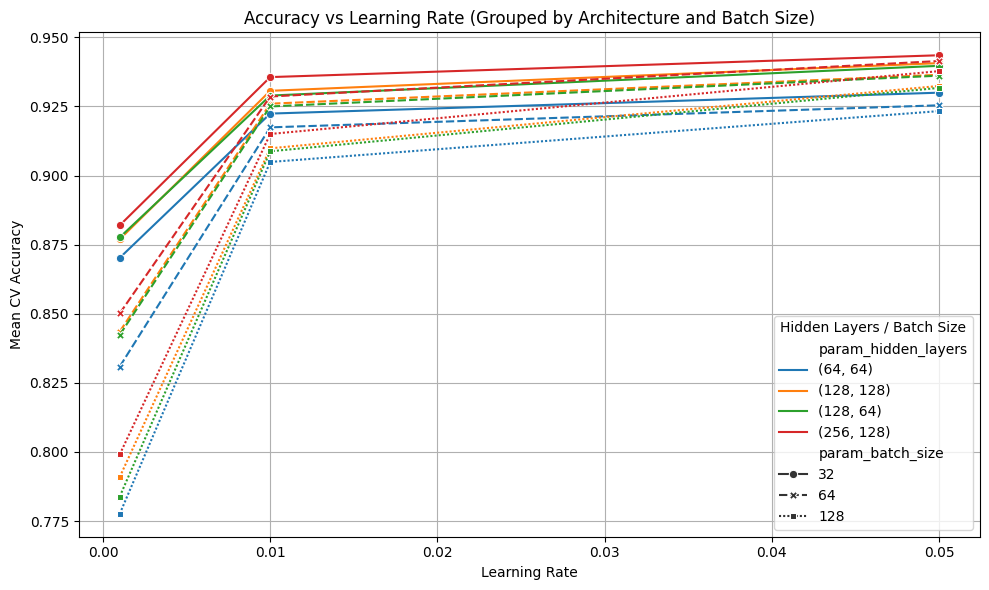

Top 5 hyperparameter combinations:


,mean_test_score,param_hidden_layers,param_learning_rate,param_batch_size
11,0.94352,"(256, 128)",0.05,32
23,0.94144,"(256, 128)",0.05,64
5,0.94068,"(128, 128)",0.05,32
8,0.93970,"(128, 64)",0.05,32
35,0.93778,"(256, 128)",0.05,128


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['mean_test_score', 'param_hidden_layers', 'param_learning_rate', 'param_batch_size']]

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_learning_rate', y='mean_test_score',
             hue='param_hidden_layers', style='param_batch_size', markers=True)
plt.title('Accuracy vs Learning Rate (Grouped by Architecture and Batch Size)')
plt.ylabel('Mean CV Accuracy')
plt.xlabel('Learning Rate')
plt.legend(title='Hidden Layers / Batch Size', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


print("Top 5 hyperparameter combinations:")
display(results_df.sort_values(by="mean_test_score", ascending=False).head(5))

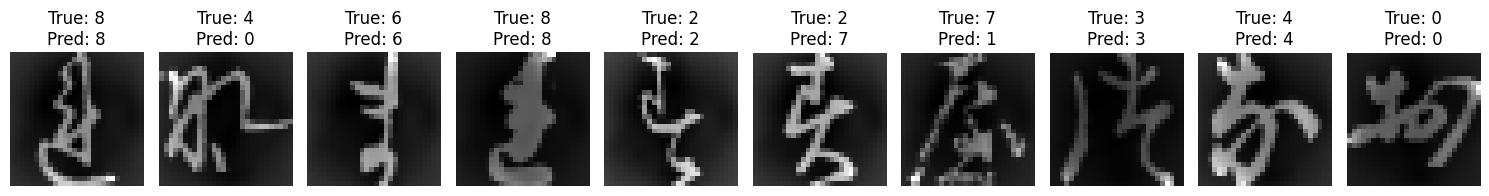

In [ ]:
num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_preds = y_pred_test[indices]

# Plot them
plt.figure(figsize=(15, 4))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}\nPred: {sample_preds[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


### Tuning for single layer MLP

In [ ]:
#this takes a long time to run!! took me ~50mins
param_grid2 = {
     'hidden_layers': [(32,), (64,), (128,), (256,)],
     'learning_rate': [0.001, 0.01, 0.05],
     'batch_size': [32, 64, 128]
}

grid_search2 = GridSearchCV(MLPClassifierWrapper(), param_grid2, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search2.fit(X_train, y_train)

#best hyperparameters
print("Best Parameters:", grid_search2.best_params_)

#testing best model
best_model2 = grid_search2.best_estimator_
y_test_pred2 = best_model2.predict(X_test)
test_accuracy2 = evaluate_acc(y_test, y_test_pred)

print(f"Best Test Accuracy: {test_accuracy2:.4f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'batch_size': 32, 'hidden_layers': (256,), 'learning_rate': 0.05}
Best Test Accuracy: 0.8907


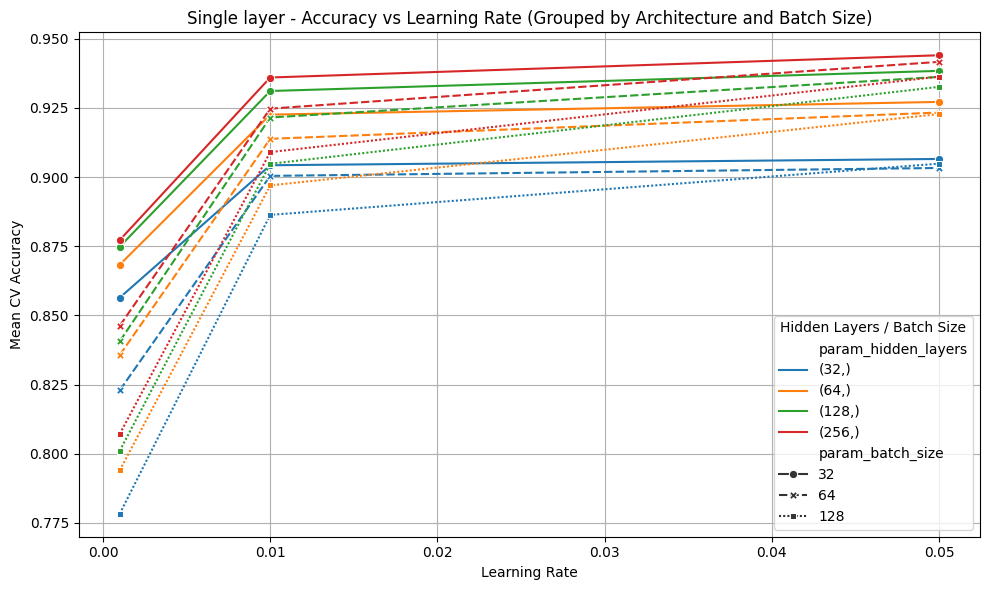

Top 5 hyperparameter combinations:


,mean_test_score,param_hidden_layers,param_learning_rate,param_batch_size
11,0.94404,"(256,)",0.05,32
23,0.94166,"(256,)",0.05,64
8,0.93840,"(128,)",0.05,32
35,0.93630,"(256,)",0.05,128
20,0.93622,"(128,)",0.05,64


In [ ]:
results_df2 = pd.DataFrame(grid_search2.cv_results_)
results_df2 = results_df2[['mean_test_score', 'param_hidden_layers', 'param_learning_rate', 'param_batch_size']]

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df2, x='param_learning_rate', y='mean_test_score',
             hue='param_hidden_layers', style='param_batch_size', markers=True)
plt.title('Single layer - Accuracy vs Learning Rate (Grouped by Architecture and Batch Size)')
plt.ylabel('Mean CV Accuracy')
plt.xlabel('Learning Rate')
plt.legend(title='Hidden Layers / Batch Size', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


print("Top 5 hyperparameter combinations:")
display(results_df2.sort_values(by="mean_test_score", ascending=False).head(5))

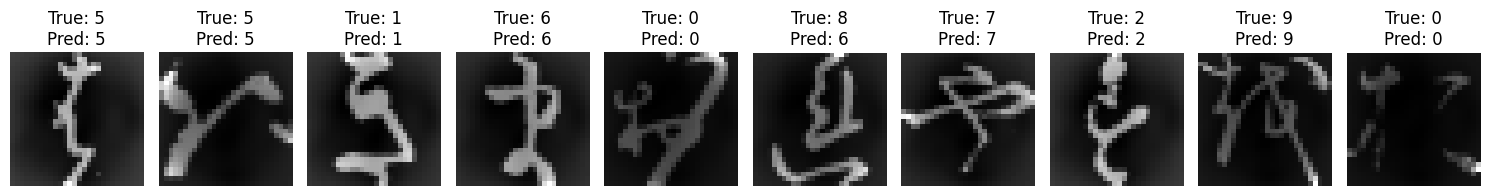

In [ ]:
num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_preds = y_pred_test[indices]

# Plot them
plt.figure(figsize=(15, 4))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}\nPred: {sample_preds[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Task 3: Experiments

## Task 3.1 : Different models

### Task 3.1.1 : MLP no hidden layer

Best training accuracy = 0.84022
Best validation accuracy = 0.8075
Test accuracy = 0.6696



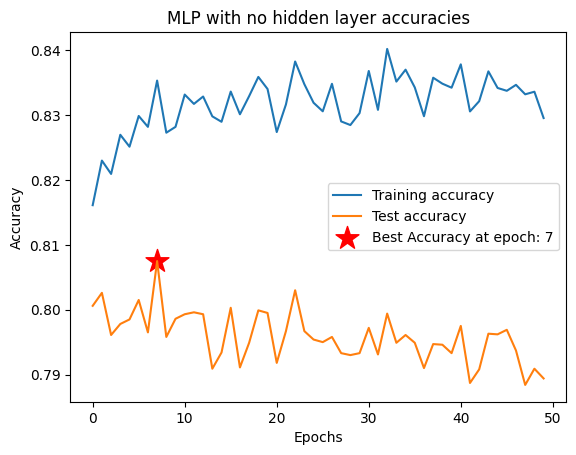

In [ ]:
MLP_no_hidden_layer = MLP(input_size=784, hidden_layers=[], output_size=10, activation_funcs=[Softmax]) # 784 input features, 0 hidden units, 10 outputs ---- Softmax used on output layer
no_hl_train_acc, no_hl_val_acc = MLP_no_hidden_layer.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = 0, learning_rate=0.05)

print(f"Best training accuracy = {max(no_hl_train_acc)}")
print(f"Best validation accuracy = {max(no_hl_val_acc)}")

no_hl_test_acc = evaluate_acc(y_test, MLP_no_hidden_layer.predict(X_test))
print(f"Test accuracy = {no_hl_test_acc}\n")

plt.plot(no_hl_train_acc, label='Training accuracy')
plt.plot(no_hl_val_acc, label='Test accuracy')
plt.scatter(MLP_no_hidden_layer.best_iteration, MLP_no_hidden_layer.best_acc, color='red', marker='*', s=300, label=f"Best Accuracy at epoch: {MLP_no_hidden_layer.best_iteration}")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP with no hidden layer accuracies')
plt.show()

### Task 3.1.2 : MLP single hidden layer

Best training accuracy = 0.99986
Best validation accuracy = 0.9544
Test accuracy = 0.8931



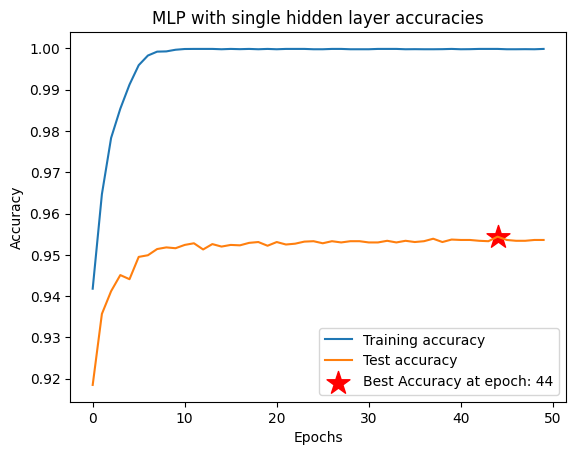

In [ ]:
MLP_single_hidden_layer = MLP(input_size=784, hidden_layers=[256,], output_size=10, activation_funcs=[Relu, Softmax])
single_hl_train_acc, single_hl_val_acc = MLP_single_hidden_layer.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = 0, learning_rate=0.05)

print(f"Best training accuracy = {max(single_hl_train_acc)}")
print(f"Best validation accuracy = {max(single_hl_val_acc)}")

single_hl_test_acc = evaluate_acc(y_test, MLP_single_hidden_layer.predict(X_test))
print(f"Test accuracy = {single_hl_test_acc}\n")

plt.plot(single_hl_train_acc, label='Training accuracy')
plt.plot(single_hl_val_acc, label='Test accuracy')
plt.scatter(MLP_single_hidden_layer.best_iteration, MLP_single_hidden_layer.best_acc, color='red', marker='*', s=300, label=f"Best Accuracy at epoch: {MLP_single_hidden_layer.best_iteration}")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP with single hidden layer accuracies')
plt.show()

### Task 3.1.3 : MLP two hidden layers

Best training accuracy = 0.99986
Best validation accuracy = 0.9569
Test accuracy = 0.9005



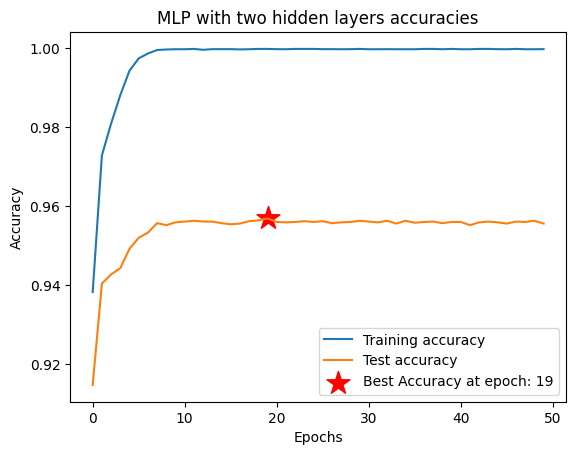

In [ ]:
MLP_two_hidden_layers = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=[Relu, Relu, Softmax])
two_hl_train_acc, two_hl_val_acc = MLP_two_hidden_layers.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd=0, learning_rate=0.05)

print(f"Best training accuracy = {max(two_hl_train_acc)}")
print(f"Best validation accuracy = {max(two_hl_val_acc)}")

two_hl_test_acc = evaluate_acc(y_test, MLP_two_hidden_layers.predict(X_test))
print(f"Test accuracy = {two_hl_test_acc}\n")

plt.plot(two_hl_train_acc, label='Training accuracy')
plt.plot(two_hl_val_acc, label='Test accuracy')
plt.scatter(MLP_two_hidden_layers.best_iteration, MLP_two_hidden_layers.best_acc, color='red', marker='*', s=300, label=f"Best Accuracy at epoch: {MLP_two_hidden_layers.best_iteration}")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MLP with two hidden layers accuracies')
plt.show()

Best validation accuracy for MLP with no hidden layer = 0.8075
Best validation accuracy for MLP with single hidden layer = 0.9544
Best validation accuracy for MLP with two hidden layers = 0.9569



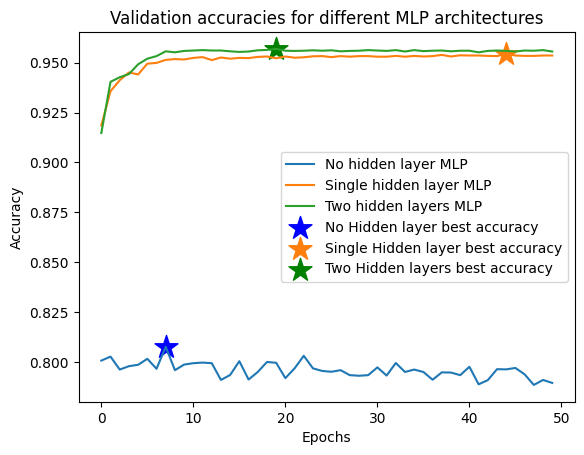

In [ ]:
print(f"Best validation accuracy for MLP with no hidden layer = {max(no_hl_val_acc)}")
print(f"Best validation accuracy for MLP with single hidden layer = {max(single_hl_val_acc)}")
print(f"Best validation accuracy for MLP with two hidden layers = {max(two_hl_val_acc)}\n")

plt.plot(no_hl_val_acc, label='No hidden layer MLP')
plt.plot(single_hl_val_acc, label='Single hidden layer MLP')
plt.plot(two_hl_val_acc, label='Two hidden layers MLP')

plt.scatter(MLP_no_hidden_layer.best_iteration, MLP_no_hidden_layer.best_acc, color='blue', marker='*', s=300, label=f"No Hidden layer best accuracy")
plt.scatter(MLP_single_hidden_layer.best_iteration, MLP_single_hidden_layer.best_acc, color='C1', marker='*', s=300, label=f"Single Hidden layer best accuracy")
plt.scatter(MLP_two_hidden_layers.best_iteration, MLP_two_hidden_layers.best_acc, color='green', marker='*', s=300, label=f"Two Hidden layers best accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracies for different MLP architectures')
plt.show()

Test accuracy for MLP with no hidden layer: 0.6696
Test accuracy for MLP with single hidden layer: 0.8931
Test accuracy for MLP with two hidden layers: 0.9005


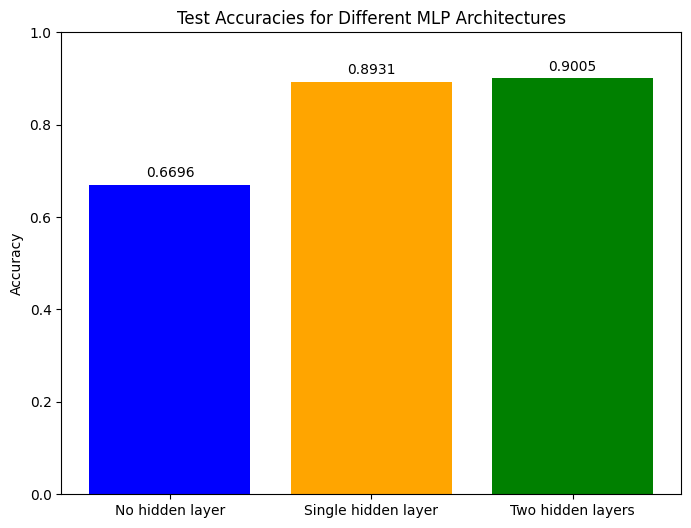

In [ ]:
print(f"Test accuracy for MLP with no hidden layer: {no_hl_test_acc:.4f}")
print(f"Test accuracy for MLP with single hidden layer: {single_hl_test_acc:.4f}")
print(f"Test accuracy for MLP with two hidden layers: {two_hl_test_acc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bars = plt.bar(['No hidden layer', 'Single hidden layer', 'Two hidden layers'],
               [no_hl_test_acc, single_hl_test_acc, two_hl_test_acc],
               color=['blue', 'orange', 'green'])

plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Test Accuracies for Different MLP Architectures')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.show()

## Task 3.2 : Activation functions

In [ ]:
MLP_two_leaky = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=[LeakyRelu, LeakyRelu, Sigmoid])
leaky_train_acc, leaky_val_acc = MLP_two_leaky.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = 0, learning_rate=0.05)

MLP_two_leaky_soft = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=[LeakyRelu, LeakyRelu, Softmax])
leaky_soft_train_acc, leaky_soft_val_acc = MLP_two_leaky_soft.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = 0, learning_rate=0.05)

MLP_two_hl_sig = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=[Relu, Relu, Sigmoid])
sig_train_acc, sig_val_acc = MLP_two_hl_sig.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = 0, learning_rate=0.05)

print(f"Best training accuracy for Leaky and Sigmoid = {max(leaky_train_acc)}")
print(f"Best validation accuracy for Leaky and Sigmoid = {max(leaky_val_acc)}")
two_leaky_test_acc = evaluate_acc(y_test, MLP_two_leaky.predict(X_test))
print(f"Test accuracy = {two_leaky_test_acc}\n")


print(f"Best training accuracy for Leaky and Softmax = {max(leaky_soft_train_acc)}")
print(f"Best validation accuracy for Leaky and Softmax = {max(leaky_soft_val_acc)}")
two_leaky_soft_test_acc = evaluate_acc(y_test, MLP_two_leaky_soft.predict(X_test))
print(f"Test accuracy = {two_leaky_soft_test_acc}\n")

print(f"Best training accuracy for Relu and Sigmoid = {max(sig_train_acc)}")
print(f"Best validation accuracy for Relu and Sigmoid = {max(sig_val_acc)}")
two_hl_sig_test_acc = evaluate_acc(y_test, MLP_two_hl_sig.predict(X_test))
print(f"Test accuracy = {two_hl_sig_test_acc}\n")

Best training accuracy for Leaky and Sigmoid = 0.99986
Best validation accuracy for Leaky and Sigmoid = 0.9602
Test accuracy = 0.9018

Best training accuracy for Leaky and Softmax = 0.99986
Best validation accuracy for Leaky and Softmax = 0.9551
Test accuracy = 0.9

Best training accuracy for Relu and Sigmoid = 0.99986
Best validation accuracy for Relu and Sigmoid = 0.9601
Test accuracy = 0.9003



Best validation accuracy for Relu and Softmax 2-HL MLP = 0.9569
Best validation accuracy for LeakyRelu and Sigmoid 2-HL MLP = 0.9602
Best validation accuracy for Leaky and Softmax = 0.9551
Best validation accuracy for Relu and Sigmoid = 0.9601

Test accuracy for Relu and Softmax 2-HL MLP = 0.9005
Test accuracy for LeakyRelu and Sigmoid 2-HL MLP = 0.9018
Test accuracy for Leaky and Softmax = 0.9
Test accuracy for Relu and Sigmoid = 0.9003



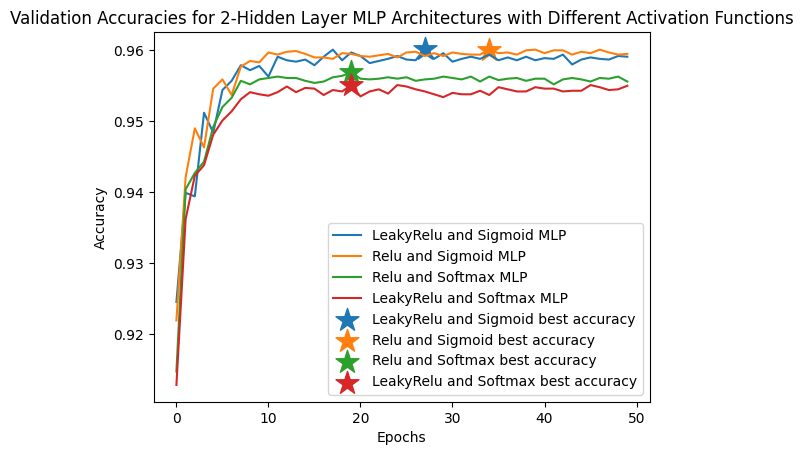

In [ ]:
print(f"Best validation accuracy for Relu and Softmax 2-HL MLP = {max(two_hl_val_acc)}")
print(f"Best validation accuracy for LeakyRelu and Sigmoid 2-HL MLP = {max(leaky_val_acc)}")
print(f"Best validation accuracy for Leaky and Softmax = {max(leaky_soft_val_acc)}")
print(f"Best validation accuracy for Relu and Sigmoid = {max(sig_val_acc)}\n")

print(f"Test accuracy for Relu and Softmax 2-HL MLP = {two_hl_test_acc}")
print(f"Test accuracy for LeakyRelu and Sigmoid 2-HL MLP = {two_leaky_test_acc}")
print(f"Test accuracy for Leaky and Softmax = {two_leaky_soft_test_acc}")
print(f"Test accuracy for Relu and Sigmoid = {two_hl_sig_test_acc}\n")


plt.plot(leaky_val_acc, label='LeakyRelu and Sigmoid MLP')
plt.plot(sig_val_acc, label='Relu and Sigmoid MLP')
plt.plot(two_hl_val_acc, label='Relu and Softmax MLP')
plt.plot(leaky_soft_val_acc, label='LeakyRelu and Softmax MLP')

plt.scatter(MLP_two_leaky.best_iteration, MLP_two_leaky.best_acc, color='C0', marker='*', s=300,
            label="LeakyRelu and Sigmoid best accuracy")
plt.scatter(MLP_two_hl_sig.best_iteration, MLP_two_hl_sig.best_acc, color='C1', marker='*', s=300,
            label="Relu and Sigmoid best accuracy")
plt.scatter(MLP_two_hidden_layers.best_iteration, MLP_two_hidden_layers.best_acc, color='C2', marker='*', s=300,
            label="Relu and Softmax best accuracy")
plt.scatter(MLP_two_leaky_soft.best_iteration, MLP_two_leaky_soft.best_acc, color='C3', marker='*', s=300,
            label="LeakyRelu and Softmax best accuracy")

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies for 2-Hidden Layer MLP Architectures with Different Activation Functions')
plt.show()


## Task 3.3 : L2 Regularization

In [ ]:
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1]

for i in range(len(lambdas)):
    MLP_lambda = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=[Relu, Relu, Softmax])
    lambda_train_acc, lambda_val_acc = MLP_lambda.fit(X_train, y_train, X_val, y_val, epochs=50, batch_size=32, loss_fn=Cross_Entropy, lambd = lambdas[i], learning_rate=0.05)
    print(f"Best training accuracy for lambda = {lambdas[i]} is {max(lambda_train_acc)}")
    print(f"Best validation accuracy for lambda = {lambdas[i]} is {max(lambda_val_acc)}")

    lambda_test_acc = evaluate_acc(y_test, MLP_lambda.predict(X_test))
    print(f"Test accuracy for lambda = {lambdas[i]} is {lambda_test_acc}\n")

    if i == 0:
      l0_val_acc = lambda_val_acc
      l0_test_acc = lambda_test_acc
      l0_best_iteration = MLP_lambda.best_iteration
    elif i == 1:
      l1_val_acc = lambda_val_acc
      l1_test_acc = lambda_test_acc
      l1_best_iteration = MLP_lambda.best_iteration
    elif i == 2:
      l2_val_acc = lambda_val_acc
      l2_test_acc = lambda_test_acc
      l2_best_iteration = MLP_lambda.best_iteration
    elif i == 3:
      l3_val_acc = lambda_val_acc
      l3_test_acc = lambda_test_acc
      l3_best_iteration = MLP_lambda.best_iteration
    elif i == 4:
      l4_val_acc = lambda_val_acc
      l4_test_acc = lambda_test_acc
      l4_best_iteration = MLP_lambda.best_iteration



Best training accuracy for lambda = 0.001 is 0.99984
Best validation accuracy for lambda = 0.001 is 0.9606
Test accuracy for lambda = 0.001 is 0.9025

Best training accuracy for lambda = 0.005 is 0.98588
Best validation accuracy for lambda = 0.005 is 0.9537
Test accuracy for lambda = 0.005 is 0.8899

Best training accuracy for lambda = 0.01 is 0.96304
Best validation accuracy for lambda = 0.01 is 0.9405
Test accuracy for lambda = 0.01 is 0.8544

Best training accuracy for lambda = 0.05 is 0.86984
Best validation accuracy for lambda = 0.05 is 0.8615
Test accuracy for lambda = 0.05 is 0.6627

Best training accuracy for lambda = 0.1 is 0.80422
Best validation accuracy for lambda = 0.1 is 0.7997
Test accuracy for lambda = 0.1 is 0.4295



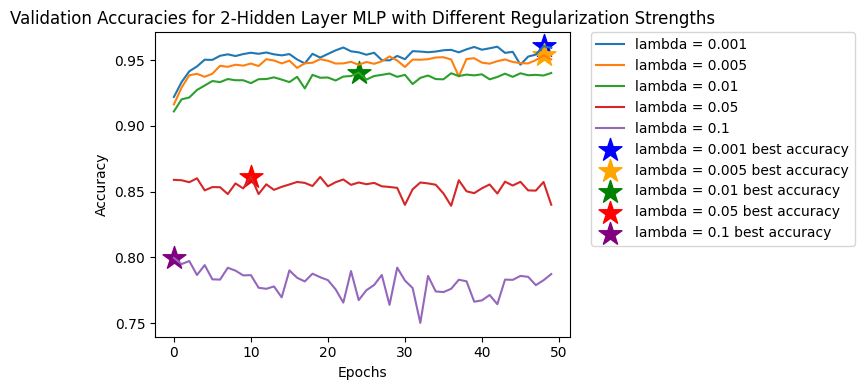

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(l0_val_acc, label='lambda = 0.001')
plt.plot(l1_val_acc, label='lambda = 0.005')
plt.plot(l2_val_acc, label='lambda = 0.01')
plt.plot(l3_val_acc, label='lambda = 0.05')
plt.plot(l4_val_acc, label='lambda = 0.1')

plt.scatter(l0_best_iteration, max(l0_val_acc), color='blue', marker='*', s=300, label="lambda = 0.001 best accuracy")
plt.scatter(l1_best_iteration, max(l1_val_acc), color='orange', marker='*', s=300, label="lambda = 0.005 best accuracy")
plt.scatter(l2_best_iteration, max(l2_val_acc), color='green', marker='*', s=300, label="lambda = 0.01 best accuracy")
plt.scatter(l3_best_iteration, max(l3_val_acc), color='red', marker='*', s=300, label="lambda = 0.05 best accuracy")
plt.scatter(l4_best_iteration, max(l4_val_acc), color='purple', marker='*', s=300, label="lambda = 0.1 best accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies for 2-Hidden Layer MLP with Different Regularization Strengths')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


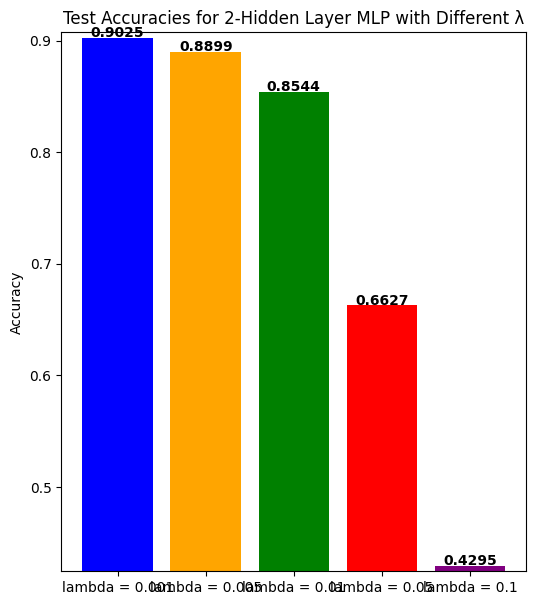

In [ ]:
lambdas = ['lambda = 0.001', 'lambda = 0.005', 'lambda = 0.01', 'lambda = 0.05', 'lambda = 0.1']
accuracies = [l0_test_acc, l1_test_acc, l2_test_acc, l3_test_acc, l4_test_acc]

plt.figure(figsize=(6, 7))

plt.bar(lambdas, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.0005, f"{acc:.4f}", ha='center', fontsize=10, fontweight='bold')

plt.ylim(min(accuracies) - 0.005, max(accuracies) + 0.005)
plt.ylabel('Accuracy')
plt.title('Test Accuracies for 2-Hidden Layer MLP with Different λ')
plt.show()

## Task 3.4 : CNN

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Original y_train shape: (50000,)
y_train_CNN shape: (50000, 10)


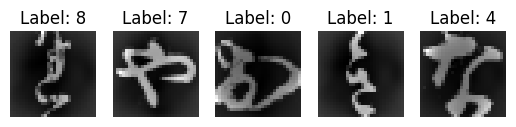

X_train_CNN shape: (50000, 28, 28, 1)
y_train_CNN shape: (50000, 10)


In [37]:
X_train_CNN = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test_CNN = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print("Original y_train shape:", y_train.shape)

if y_train.ndim == 1:
    y_train_CNN = keras.utils.to_categorical(y_train, 10)
else:
    y_train_CNN = y_train

if y_test.ndim == 1:
    y_test_CNN = keras.utils.to_categorical(y_test, 10)
else:
    y_test_CNN = y_test

val_size = 5000
X_val_CNN = X_train_CNN[-val_size:]
y_val_CNN = y_train_CNN[-val_size:]
X_tr_CNN = X_train_CNN[:-val_size]
y_tr_CNN = y_train_CNN[:-val_size]

print("y_train_CNN shape:", y_train_CNN.shape)

y_sample = np.argmax(y_train_CNN[:5], axis=1)
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_CNN[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_sample[i]}")
    plt.axis('off')
plt.show()

print("X_train_CNN shape:", X_train_CNN.shape)
print("y_train_CNN shape:", y_train_CNN.shape)

### Hidden units experiment

In [35]:
def create_cnn_model(hidden_units=64, learning_rate = 0.01):
    model = Sequential([
        # First convolutional layer
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Fully connected layers
        layers.Dense(hidden_units, activation='relu'),
        layers.Dense(hidden_units, activation='relu'),

        layers.Dense(10, activation='softmax')
    ])

    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

def train_cnn_model(hidden_units, epochs=100, batch_size=32):
    print(f"\n=== Training CNN with {hidden_units} hidden units ===")

    model = create_cnn_model(hidden_units)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Use early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.0001,  # Stop if the change in validation loss is less than 0.0001
        restore_best_weights=True
    )

    history = model.fit(
        X_train_CNN, y_train_CNN,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_CNN, y_val_CNN),
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test_CNN, y_test_CNN)
    print(f"Test accuracy with {hidden_units} hidden units: {test_acc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')

    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    plt.scatter(best_epoch, best_val_acc, marker='*', color='red', s=200, label='Best val accuracy')

    plt.title(f'Accuracy (Hidden Units: {hidden_units})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Loss (Hidden Units: {hidden_units})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'cnn_training_hidden_{hidden_units}.png')
    plt.show()

    model.save(f'kmnist_cnn_model_{hidden_units}.h5')

    return {
        'hidden_units': hidden_units,
        'test_accuracy': test_acc,
        'history': history.history
    }




=== Training CNN with 32 hidden units ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.5226 - loss: 1.3348 - val_accuracy: 0.8790 - val_loss: 0.3735
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.8917 - loss: 0.3460 - val_accuracy: 0.9252 - val_loss: 0.2455
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9251 - loss: 0.2363 - val_accuracy: 0.9468 - val_loss: 0.1822
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9441 - loss: 0.1788 - val_accuracy: 0.9530 - val_loss: 0.1448
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9541 - loss: 0.1500 - val_accuracy: 0.9596 - val_loss: 0.1337
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9605 - loss: 0.1233 - val_accuracy: 0.9622 - val_loss: 0.1164
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9683 - loss: 0.0999 - val_accuracy: 0.9596 - val_loss: 0.1265
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 

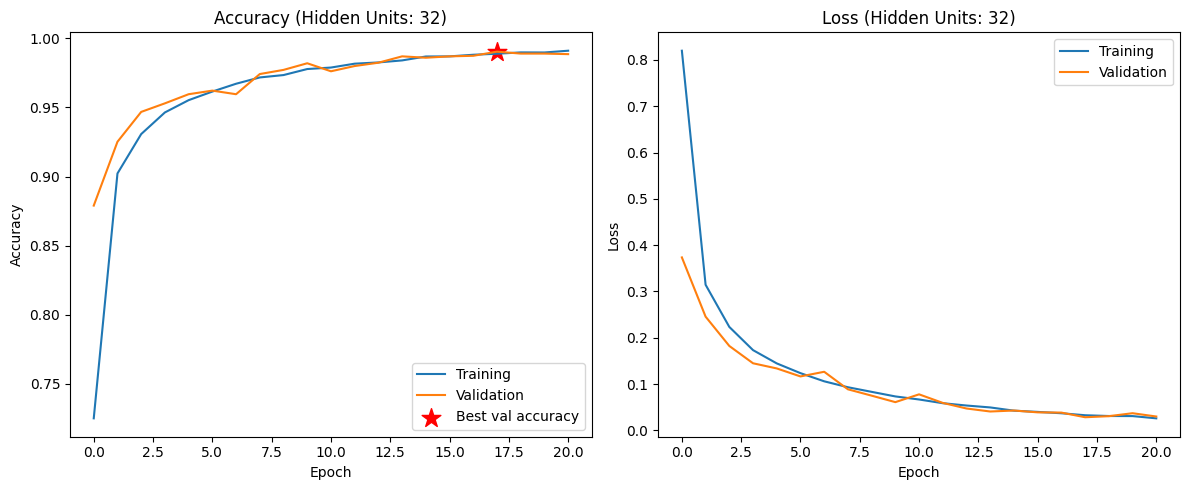


=== Model Performance Summary ===
Hidden Units: 32
Test Accuracy: 0.9266

=== Training CNN with 64 hidden units ===
Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.5603 - loss: 1.2372 - val_accuracy: 0.8952 - val_loss: 0.3302
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9103 - loss: 0.2862 - val_accuracy: 0.9372 - val_loss: 0.2039
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9423 - loss: 0.1848 - val_accuracy: 0.9462 - val_loss: 0.1667
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9531 - loss: 0.1509 - val_accuracy: 0.9614 - val_loss: 0.1193
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.9625 - loss: 0.1191 - val_accuracy: 0.9702 - val_loss: 0.0995
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9704 - loss: 0.0955 - val_accuracy: 0.9756 - val_loss: 0.0800
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.9751 - loss: 0

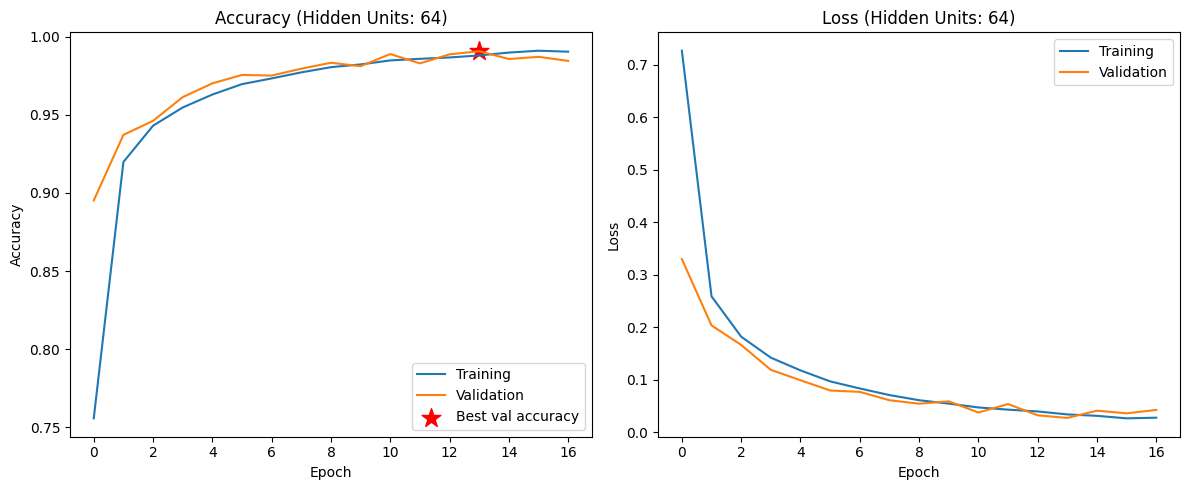


=== Model Performance Summary ===
Hidden Units: 64
Test Accuracy: 0.9268

=== Training CNN with 128 hidden units ===
Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.6238 - loss: 1.0858 - val_accuracy: 0.9142 - val_loss: 0.2707
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.9231 - loss: 0.2440 - val_accuracy: 0.9440 - val_loss: 0.1794
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9508 - loss: 0.1583 - val_accuracy: 0.9656 - val_loss: 0.1125
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9669 - loss: 0.1053 - val_accuracy: 0.9710 - val_loss: 0.0892
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.9722 - loss: 0.0864 - val_accuracy: 0.9720 - val_loss: 0.0892
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9790 - loss: 0.0650 - val_accuracy: 0.9810 - val_loss: 0.0575
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9839 - loss: 

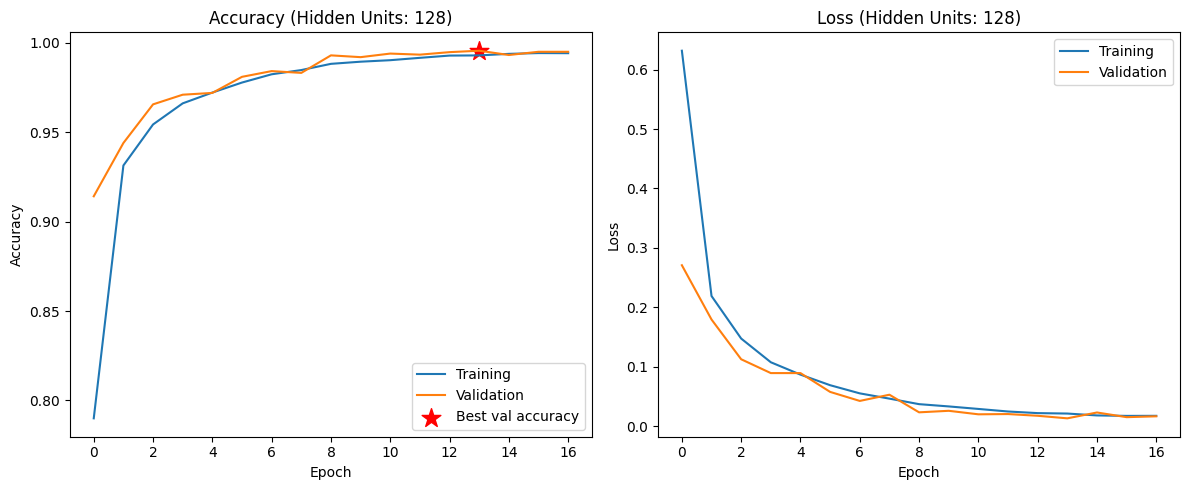


=== Model Performance Summary ===
Hidden Units: 128
Test Accuracy: 0.9371

=== Training CNN with 256 hidden units ===
Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - accuracy: 0.6617 - loss: 0.9771 - val_accuracy: 0.9308 - val_loss: 0.2299
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9337 - loss: 0.2092 - val_accuracy: 0.9560 - val_loss: 0.1337
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.9615 - loss: 0.1192 - val_accuracy: 0.9742 - val_loss: 0.0875
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.9722 - loss: 0.0863 - val_accuracy: 0.9700 - val_loss: 0.0914
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.9797 - loss: 0.0634 - val_accuracy: 0.9784 - val_loss: 0.0651
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.9847 - loss: 0.0482 - val_accuracy: 0.9846 - val_loss: 0.0439
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9873 - loss:

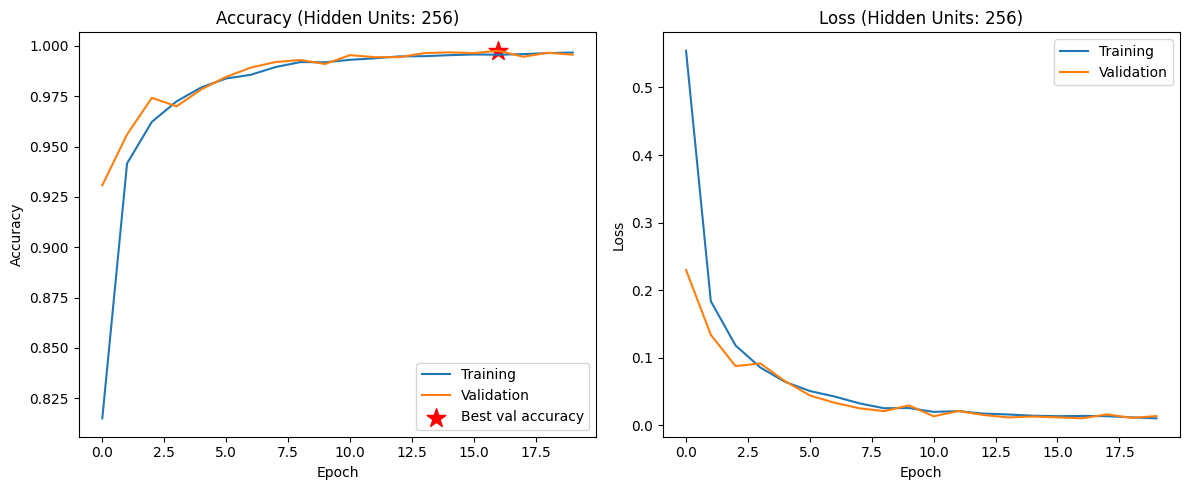


=== Model Performance Summary ===
Hidden Units: 256
Test Accuracy: 0.9478


In [ ]:
results = []

for hidden_units_to_train in [32, 64, 128, 256]:
  result = train_cnn_model(hidden_units_to_train)
  print(f"\n=== Model Performance Summary ===")
  print(f"Hidden Units: {result['hidden_units']}")
  print(f"Test Accuracy: {result['test_accuracy']:.4f}")

  results.append(result)

Results:
Hidden Units: 32, Validation Accuracy: 0.9904000163078308,Test Accuracy: 0.9266
Hidden Units: 64, Validation Accuracy: 0.9908000230789185,Test Accuracy: 0.9268
Hidden Units: 128, Validation Accuracy: 0.9955999851226807,Test Accuracy: 0.9371
Hidden Units: 256, Validation Accuracy: 0.9976000189781189,Test Accuracy: 0.9478


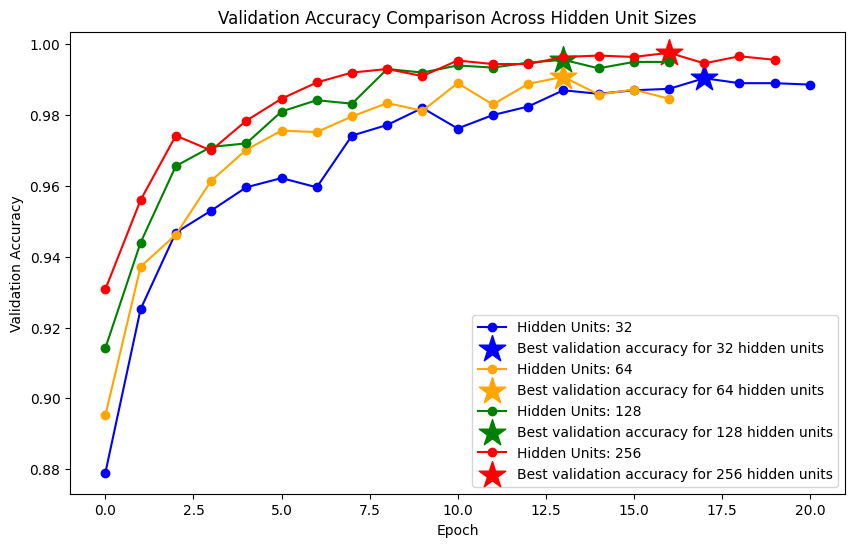

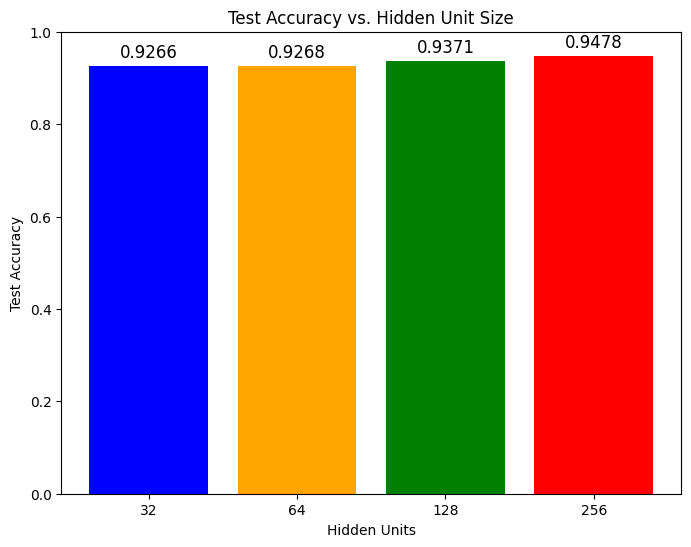

In [ ]:
print("Results:")
for result in results:
    print(f"Hidden Units: {result['hidden_units']}, Validation Accuracy: {max(result['history']['val_accuracy'])},Test Accuracy: {result['test_accuracy']:.4f}")

color_map = {
    32: 'blue',
    64: 'orange',
    128: 'green',
    256: 'red'
}

plt.figure(figsize=(10, 6))
for result in results:
    hu = result['hidden_units']
    c = color_map.get(hu, 'black')
    val_acc = result['history']['val_accuracy']

    plt.plot(val_acc, marker='o', label=f"Hidden Units: {hu}", color=c)

    best_epoch = np.argmax(val_acc)
    best_val_acc = val_acc[best_epoch]

    plt.scatter(best_epoch, best_val_acc, marker='*', color=c, s=400, label=f"Best validation accuracy for {hu} hidden units")

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison Across Hidden Unit Sizes')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(8, 6))
hidden_units = [result['hidden_units'] for result in results]
test_accuracies = [result['test_accuracy'] for result in results]
bar_colors = [color_map.get(hu, 'black') for hu in hidden_units]
plt.bar([str(hu) for hu in hidden_units], test_accuracies, color=bar_colors)
plt.xlabel('Hidden Units')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Hidden Unit Size')
plt.ylim(0, 1)
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center', va='bottom', fontsize=12)
plt.show()



### Comparing CNN vs. MLP


=== Training CNN with 256 hidden units ===
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.6399 - loss: 1.0258 - val_accuracy: 0.9236 - val_loss: 0.2473
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9326 - loss: 0.2162 - val_accuracy: 0.9460 - val_loss: 0.1609
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.9573 - loss: 0.1313 - val_accuracy: 0.9612 - val_loss: 0.1237
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - accuracy: 0.9693 - loss: 0.0931 - val_accuracy: 0.9768 - val_loss: 0.0748
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.9784 - loss: 0.0669 - val_accuracy: 0.9802 - val_loss: 0.0554
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9856 - loss: 0.0481 - val_accuracy: 0.9822 - val_loss: 0.0514
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.9848 - loss: 0.0464 - val_accuracy: 0.9880 - val_loss: 0.0340
Epoch 8/50
1563/1563 ━━━━━━━━━━━

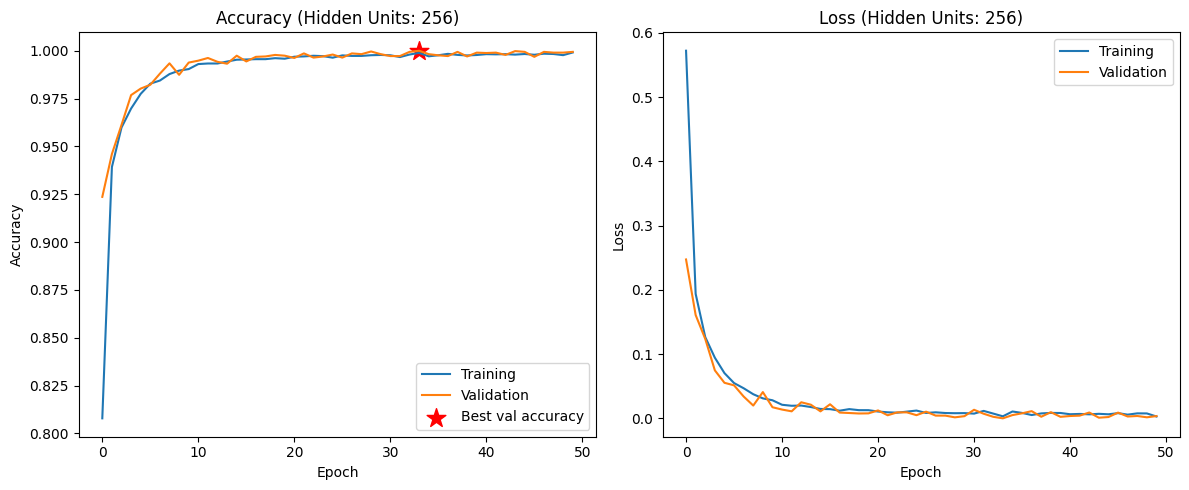


=== Model Performance Summary ===
Hidden Units: 256
Test Accuracy: 0.9571


In [38]:
import numpy as np
import matplotlib.pyplot as plt

def train_cnn_model(hidden_units, epochs=50, batch_size=32):
    print(f"\n=== Training CNN with {hidden_units} hidden units ===")

    model = create_cnn_model(hidden_units)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_CNN, y_train_CNN,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_CNN, y_val_CNN),
        verbose=1,
    )

    test_loss, test_acc = model.evaluate(X_test_CNN, y_test_CNN)
    print(f"Test accuracy with {hidden_units} hidden units: {test_acc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')

    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    plt.scatter(best_epoch, best_val_acc, marker='*', color='red', s=200, label='Best val accuracy')

    plt.title(f'Accuracy (Hidden Units: {hidden_units})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Loss (Hidden Units: {hidden_units})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'cnn_training_hidden_{hidden_units}.png')
    plt.show()

    model.save(f'kmnist_cnn_model_{hidden_units}.h5')

    return {
        'hidden_units': hidden_units,
        'test_accuracy': test_acc,
        'history': history.history
    }


best_model_result = train_cnn_model(256)
print(f"\n=== Model Performance Summary ===")
print(f"Hidden Units: {best_model_result['hidden_units']}")
print(f"Test Accuracy: {best_model_result['test_accuracy']:.4f}")

Best validation accuracy for MLP with no hidden layer = 0.8075
Best validation accuracy for MLP with single hidden layer = 0.9544
Best validation accuracy for Relu and Softmax 2-HL MLP = 0.9569
Best validation accuracy for LeakyRelu and Sigmoid 2-HL MLP = 0.9602
Best validation accuracy for CNN = 1.0

Test accuracy for no hidden layer MLP = 0.6696
Test accuracy for single hidden layer MLP = 0.8931
Test accuracy for Relu and Softmax 2-HL MLP = 0.9005
Test accuracy for LeakyRelu and Sigmoid 2-HL MLP = 0.9018
Test accuracy for CNN = 0.957099974155426



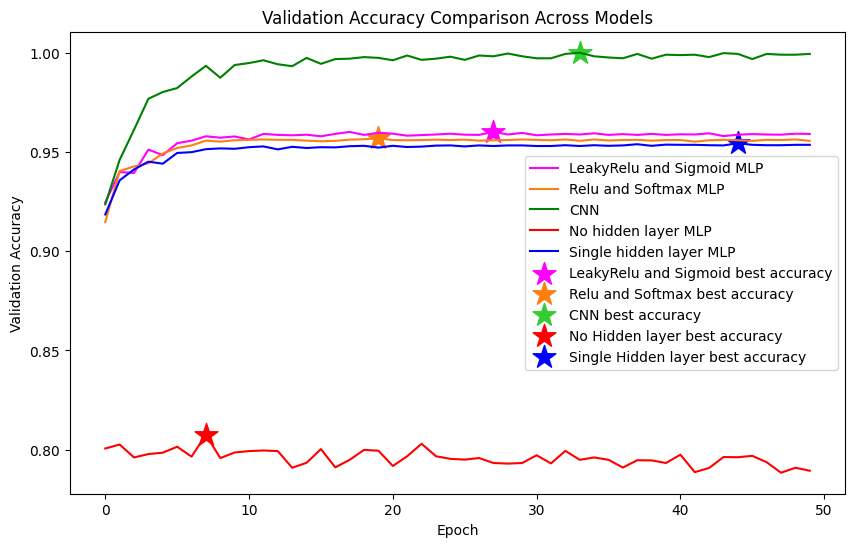

In [43]:
# Compare MLP vs CNN
cnn_128_hu = best_model_result['test_accuracy']

print(f"Best validation accuracy for MLP with no hidden layer = {max(no_hl_val_acc)}")
print(f"Best validation accuracy for MLP with single hidden layer = {max(single_hl_val_acc)}")
print(f"Best validation accuracy for Relu and Softmax 2-HL MLP = {max(two_hl_val_acc)}")
print(f"Best validation accuracy for LeakyRelu and Sigmoid 2-HL MLP = {max(leaky_val_acc)}")
print(f"Best validation accuracy for CNN = {max(best_model_result['history']['val_accuracy'])}\n")

print(f"Test accuracy for no hidden layer MLP = {no_hl_test_acc}")
print(f"Test accuracy for single hidden layer MLP = {single_hl_test_acc}")
print(f"Test accuracy for Relu and Softmax 2-HL MLP = {two_hl_test_acc}")
print(f"Test accuracy for LeakyRelu and Sigmoid 2-HL MLP = {two_leaky_test_acc}")
print(f"Test accuracy for CNN = {cnn_128_hu}\n")

plt.figure(figsize=(10, 6))

plt.plot(leaky_val_acc, label='LeakyRelu and Sigmoid MLP', color='magenta')
plt.plot(two_hl_val_acc, label='Relu and Softmax MLP', color='C1')
plt.plot(best_model_result['history']['val_accuracy'], label='CNN', color='green')
plt.plot(no_hl_val_acc, label='No hidden layer MLP', color='red')
plt.plot(single_hl_val_acc, label='Single hidden layer MLP', color='blue')

plt.scatter(MLP_two_leaky.best_iteration, MLP_two_leaky.best_acc,
            color='magenta', marker='*', s=300,
            label="LeakyRelu and Sigmoid best accuracy")

plt.scatter(MLP_two_hidden_layers.best_iteration, MLP_two_hidden_layers.best_acc,
            color='C1', marker='*', s=300,
            label="Relu and Softmax best accuracy")

plt.scatter(np.argmax(best_model_result['history']['val_accuracy']),
            max(best_model_result['history']['val_accuracy']),
            color='limegreen', marker='*', s=300,
            label="CNN best accuracy")

plt.scatter(MLP_no_hidden_layer.best_iteration, MLP_no_hidden_layer.best_acc,
            color='red', marker='*', s=300,
            label="No Hidden layer best accuracy")

plt.scatter(MLP_single_hidden_layer.best_iteration, MLP_single_hidden_layer.best_acc,
            color='blue', marker='*', s=300,
            label="Single Hidden layer best accuracy")

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison Across Models')
plt.legend(loc='best')
plt.show()


# Extra Experiments


## K-fold cross validation


Fold 1
Validation Accuracy for fold 1: 0.9555

Fold 2
Validation Accuracy for fold 2: 0.9525

Fold 3
Validation Accuracy for fold 3: 0.9522

Fold 4
Validation Accuracy for fold 4: 0.9524

Fold 5
Validation Accuracy for fold 5: 0.9537

Average CV Accuracy: 0.9532599999999999


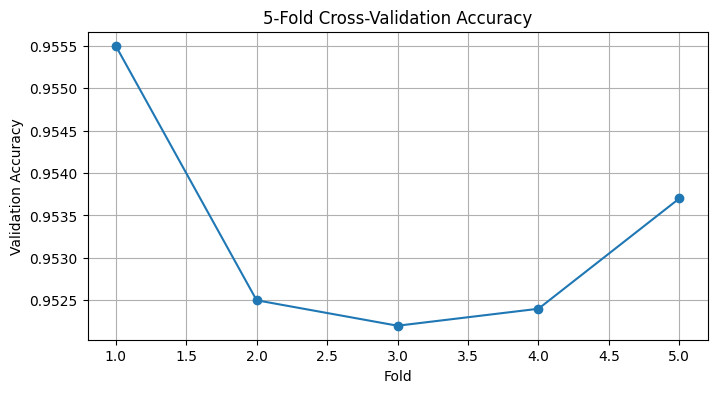

In [33]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold + 1}")

    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    # Define activation funcs and model
    activation_funcs = [Relu, Relu, Softmax]
    mlp = MLP(input_size=784, hidden_layers=[256, 128], output_size=10, activation_funcs=activation_funcs)

    # Train model
    mlp.fit(X_tr, y_tr, X_val, y_val,
            epochs=20, batch_size=32, learning_rate=0.05, loss_fn=Cross_Entropy, lambd=0)

    # Evaluate on validation fold
    y_val_pred = mlp.predict(X_val)
    acc = evaluate_acc(y_val, y_val_pred)
    print(f"Validation Accuracy for fold {fold + 1}: {acc:.4f}")
    cv_scores.append(acc)

print("\nAverage CV Accuracy:", np.mean(cv_scores))

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o')
plt.title("5-Fold Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()